In [1]:
#@title Let's download our data and set up packages while I discuss the intro below! Just ignore any warnings here.
!mamba install -c conda-forge rdkit

!pip install --pre deepchem
import deepchem

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/delaney-processed.csv"
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/tox21.csv.gz"

import gzip
import shutil
with gzip.open('tox21.csv.gz', 'rb') as f_in:
    with open('tox21.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


from deepchem.utils.save import load_from_disk

# Data Structures
import numpy as np
import pandas as pd

# Graphing
import matplotlib.pyplot as plt

# Metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics

# ML Models
from deepchem.models import GraphConvModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

/bin/bash: mamba: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.8/701.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 22.5 MB/s eta 0:00:00


--2023-01-31 20:19:24--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/delaney-processed.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/csv]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.001s  

2023-01-31 20:19:24 (68.9 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]

--2023-01-31 20:19:25--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/tox21.csv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com

The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.


Each year, the FDA approves 40 - 50 new drugs, targeting a variety of illnesses and diseases!

But how successful and cost-effective is the process?
a few key components of the drug discovery process:
1. Identifying a target for which to design a drug.
2. Thousands of potential drugs must be tested to determine their effect on the target.
3. Promising drug candidates are then tested in animals and then humans. Human trials take place in 3 phases to test for both safety and efficacy.
Many stage(s) of the drug discovery process could be made more efficient with ML
to reduce the time from target identification to clinical trials. 

![alt text](https://www.researchgate.net/profile/Niroshini-Nirmalan/publication/308045230/figure/fig1/AS:613907634872358@1523378394724/Drug-discovery-and-development-timeline-The-current-drug-approval-pipeline-can-take-15.png)

Nice! Now, that i have gone through the exploring the drug development pipeline, I build an ML model for drug discovery. Using a specialized scientific library called `deepchem`, I explore two stages of the drug discovery process to see how AI can help humans screen drug candidates! I do:
*   Predict solubility using linear regression and graph neural networks
*   Predict toxicity using graph neural networks
*   See what portion of molecules get through the screenings!

# Determining Molecular Solubility

One of the biggest early challenges in drug discovery is to find drugs that will be [absorbed by the human body](https://www.technologynetworks.com/drug-discovery/articles/what-is-adme-336683).

In this notebook, I start by predicting the **solubility** of various drug candidates: **how much of the drug can dissolve in water**. My task is to find soluble molecules which can circulate through the bloodstream!

For this task, I use the `deepchem` and `rdkit` libraries. I also explore multiple ML models including graph neural networks (GNNs).


Now, let's take a look at what the first 5 rows of `delaney-processed.csv` look like! This is the file with the solubility information. 

In [2]:
solubility_data = pd.read_csv("delaney-processed.csv")
solubility_data.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [3]:
solubility_data.shape

(1128, 10)

data matrix columns represent:

*   **Compound ID**: The chemical compound name
*   **ESOL predicted log solubility in mols per litre**: The predicted solubility for each compound using a standard method, ESOL. This represents the ability of a compound to dissolve in a non-polar solvent (oils, lipids).
*   **measured log solubility in mols per litre**: The measured solubility for each compound. This is what we're trying to predict!
*   **smiles**: The string notation representation for each compound's molecular structure.

**Optional**: If you're interested in the chemistry, read on:
*   **Minimum Degree**: The minimum number of bonds to any atom in the compound.
*   **Molecular Weight**: The molar mass of the compount in g/mol.
*   **Number of H- Bond Donors**: The number of hydrogen atoms in the molecule that are "donated" to form hydrogen bonds.
*   **Number of Rotatable Bonds**: The number of bonds that are connected to "non-terminal heavy atoms" that aren't part of a ring. 
*   **Polar Surface Area**: The total surface area of the polar atoms and molecules. Examples of polar molecules are are water and ammonia.
*   **Number of Rings**: The number of rings present on the molecular diagram. For example, Amigdalin has 3 rings, as shown in this image:

![alt text](https://file.medchemexpress.com/product_pic/hy-n0190.gif)


##Baseline: Predicting Solubility with Linear Regression
Now, let's determine how we can begin predicting solubility! 

To begin predicting solubility, I start with linear regression as a baseline to compare to GNN. 
Here, I present the `X` (raw data) and `y` (output) variables.

In [4]:
input_cols = ['Minimum Degree','Molecular Weight','Number of H-Bond Donors','Number of Rings','Number of Rotatable Bonds','Polar Surface Area'] # TODO: [ FILL IN INPUTS ]
output_cols = ['measured log solubility in mols per litre']

X = solubility_data[input_cols]
y = solubility_data[output_cols]

Now, let's perform a test/train split with 20% testing data, **without shuffling**:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

Now, let's initialize and train a linear regression model.

In [6]:
import sklearn
from sklearn import linear_model

lm = sklearn.linear_model.LinearRegression()
lm.fit(X_train,y_train)
preds = lm.predict(X_test)

To calculate the peformance, I use the R^2 metric and the function `metrics.r2_score`. I've used this metric to evaluate my previous linear regression models. **Note**: An R^2 value is within the range of 0 to 1, and greater values are better.

In [7]:
metrics.r2_score(y_test,preds)

0.6024918982930053

This prediction seem to be valuable and good however R^2 can be a little hard to interpret, so let's visualize it at a plot:

Text(0, 0.5, 'Predicted Log Solubility')

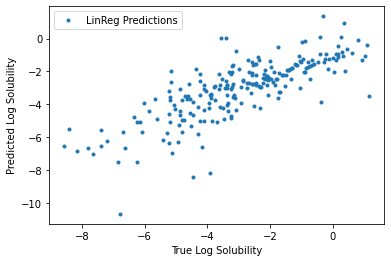

In [8]:
plt.plot(y_test, preds, '.')
plt.legend(['LinReg Predictions'])
plt.xlabel("True Log Solubility")
plt.ylabel("Predicted Log Solubility")

Reasonable amount of the predicted values are matching with the true log solubility. We can clearly see that.

### Comparing with ESOL

At the point, I wonder about how my prediction compares to the ESOL predictions - those actually also come from a [linear regression model](https://pubs.acs.org/doi/abs/10.1021/ci034243x) trained on a bigger dataset. Their predictions are giving higher precision than ours since they are takinga bigger data set to train. Here is the plot to compare the two predictions: 


In [9]:
esol_pred = solubility_data['ESOL predicted log solubility in mols per litre'].loc[y_test.index]
esol_pred

902    -4.795
903    -1.191
904    -3.693
905    -3.199
906    -4.116
        ...  
1123   -2.608
1124   -0.908
1125   -3.323
1126   -2.245
1127   -4.320
Name: ESOL predicted log solubility in mols per litre, Length: 226, dtype: float64

Text(0, 0.5, 'Predicted Log Solubility')

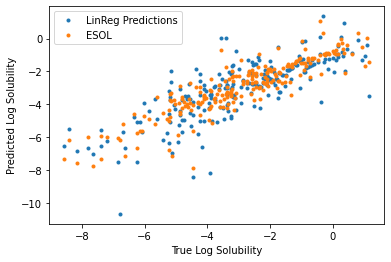

In [10]:
plt.plot(y_test, preds, '.')
plt.plot(y_test, esol_pred, '.')
plt.legend(['LinReg Predictions','ESOL'])
plt.xlabel("True Log Solubility")
plt.ylabel("Predicted Log Solubility")

In [11]:
metrics.r2_score(y_test,esol_pred)

0.7839834529021221

#Graph Neural Networks

Until now i have used molecules' chemical properties to build my predictions. Now, using GNNs, I should be able to directly use the molecules' structure, by representing each molecule as a **graph** of nodes and connections. I will compare if it gives better results

![alt text](https://snappygoat.com/b/a59dd47ded9e6b82231b2cbe1af91e56c8e0e291)

There are 5 nodes and 4 connections are there in this molecule of Methane (CH4).

Getting the molecules structure from the "smiles" column:

In [12]:
loader = deepchem.data.CSVLoader(tasks=["measured log solubility in mols per litre"], 
                                 feature_field="smiles", 
                                 featurizer=deepchem.feat.ConvMolFeaturizer())
solubility_smiles_data = loader.create_dataset("delaney-processed.csv")

splitter = deepchem.splits.IndexSplitter()
sol_train_dataset, sol_test_dataset = splitter.train_test_split(solubility_smiles_data,
                                                                 frac_train=0.8)

Let's define and train the model

In [13]:
import warnings
warnings.filterwarnings('ignore')
sol_gnn = GraphConvModel(n_tasks=1, mode="regression",dropout=0.2)
sol_gnn.fit(sol_train_dataset,nb_epoch=600)

0.13025205612182617

This value is my most recent loss. 

In [15]:
gnn_pred = sol_gnn.predict(sol_test_dataset) 
metrics.r2_score(y_test,gnn_pred)

0.722448335166261

Text(0, 0.5, 'Predicted Log Solubility')

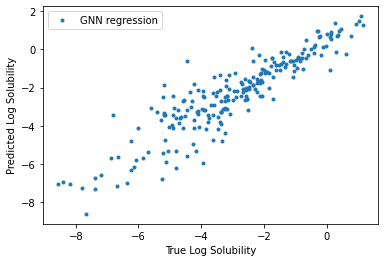

In [16]:
plt.plot(y_test, gnn_pred, '.')
plt.legend(['GNN regression'])
plt.xlabel("True Log Solubility")
plt.ylabel("Predicted Log Solubility")

This is the best estimated solubility for each molecule I got!  
Now we have a pretty good estimated solubility for each molecule! How can we use that to choose promising drug candidates?

As a very rough estimate, we can consider a molecule **soluble** if its log solubility (moles/liter) is greater than 0. **According to our GNN model, what percent of drugs in our test set are soluble**? How many drug candidates can we move forward?

In [17]:
gnn_pred_series = pd.Series(gnn_pred.squeeze(), index = y_test.index)
soluble = gnn_pred_series[gnn_pred_series > 0]
print (len(soluble)/len(gnn_pred_series))
solubility_data.loc[soluble.index]

0.11504424778761062


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
903,Ethyl propionate,-1.191,1,102.133,0,0,2,26.30,-0.660,CCOC(=O)CC
909,2-cyanoguanidine,0.361,1,84.082,2,0,0,88.19,-0.310,NC(N)=NC#N
919,Methyl acetate,-0.416,1,74.079,0,0,0,26.30,0.460,COC(=O)C
932,Pteridine,-0.906,2,132.126,0,2,0,51.56,0.020,c2cnc1ncncc1n2
940,Nitromethane,-0.042,1,61.040,0,0,0,43.14,0.260,CN(=O)=O
954,"3,5-Dimethylpyridine",-2.098,1,107.156,0,1,0,12.89,0.380,Cc1cncc(C)c1
974,3-Methyl-2-butanone,-0.912,1,86.134,0,0,1,17.07,-0.120,CC(C)C(=O)C
983,Ethanol,0.020,1,46.069,1,0,0,20.23,1.100,CCO
991,aminopyrine,-2.129,1,231.299,0,2,2,30.17,-0.364,CN(C)c2c(C)n(C)n(c1ccccc1)c2=O
992,3-Pentanol,-0.970,1,88.150,1,0,2,20.23,-0.240,CCC(O)CC


We can only move forward a small portion of our candidates! And this is just one early stage in the drug discovery pipeline...

## Exploring Deepchem formats


In [18]:
print (sol_train_dataset) #All data
print (sol_train_dataset.X) #X data - molecules
print (sol_train_dataset.X[0]) #First molecule

<DiskDataset X.shape: (902,), y.shape: (902, 1), w.shape: (902, 1), ids: ['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '
 'Cc1occc1C(=O)Nc2ccccc2' 'CC(C)=CCCC(C)=CC(=O)' ...
 'ClC1C=CC2C1C3(Cl)C(=C(Cl)C2(Cl)C3(Cl)Cl)Cl'
 'CCC(C)C1(CC(Br)=C)C(=O)NC(=O)NC1=O '
 'CC1(C)C(C(=O)OC(C#N)c2cccc(Oc3ccccc3)c2)C1(C)C'], task_names: ['measured log solubility in mols per litre']>


A ConvMol object represents a single molecule. There's lots of information 

In [19]:
print(sol_train_dataset.X[0].max_deg)
print(sol_train_dataset.X[0].min_deg)
print(sol_train_dataset.X[0].deg_list)
print(sol_train_dataset.X[0].canon_adj_list)

10
0
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[[21], [22], [23], [8], [15], [27], [29], [30], [3, 31], [13, 12], [11, 13], [20, 10], [9, 20], [10, 9], [26, 24], [25, 4], [24, 25], [28, 19], [31, 28], [17, 26], [25, 11, 12], [23, 0, 22], [21, 1, 26], [24, 2, 21], [14, 16, 23], [16, 15, 20], [19, 14, 22], [30, 5, 29], [18, 17, 30], [27, 6, 31], [28, 7, 27], [8, 18, 29]]


Let's see the molecule's numerical representation that's fed into the GNN: a vector for each atom.


In [21]:
my_molecule = sol_train_dataset.X[0] #Choose any index you want!
print (my_molecule.n_atoms) #Number of atoms
atom_features = my_molecule.get_atom_features()
print (atom_features)
print (atom_features.shape)

32
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(32, 75)


## Determining Molecular Toxicity

I'll use GNNs to predict toxicity from the SMILES representation. I'll use a different dataset here, stored in tox21.csv.

In [22]:
toxicity_data = pd.read_csv("tox21.csv")
toxicity_data.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


**Each column represents a different type of assay, or experiment.** Those that start with NR are Nuclear Receptor Signaling Panels and those that start with SR are Stress Response Panels. Read more about the data [here](https://tripod.nih.gov/tox21/challenge/data.jsp). 

Measuring these responses tells us whether the body is trying to fight off something it thinks is toxic. Each column shows a different toxicity indicator, so we'll train models for each! Each column is a different *task* to be learned. 

Let's load up our dataset!

In [23]:
_, datasets, transformers = deepchem.molnet.load_tox21(featurizer='GraphConv')
tox_train_dataset, tox_valid_dataset, tox_test_dataset = datasets

Next I create a GNN model for toxicity and train it for 20 epochs (much bigger dataset).

In [25]:
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

tox_gnn = GraphConvModel(n_tasks=12, mode='classification', dropout=0.2)
tox_gnn.fit(tox_train_dataset, nb_epoch=20)

0.7361455917358398

###Evaluating our Model
Since we're doing twelve different classifications, evaluating our model is a little trickier. Let's get our raw predictions on the test data:



In [27]:
tox_pred = tox_gnn.predict(tox_test_dataset)[:,:,1]
tox_pred

array([[0.46719941, 0.4819703 , 0.10074761, ..., 0.38041553, 0.2359608 ,
        0.08727048],
       [0.2814802 , 0.17083873, 0.60504895, ..., 0.6813813 , 0.52844787,
        0.8058429 ],
       [0.14253409, 0.06452057, 0.10237732, ..., 0.6439393 , 0.8880453 ,
        0.25238463],
       ...,
       [0.35704637, 0.3575775 , 0.75816077, ..., 0.59245706, 0.5905529 ,
        0.3175774 ],
       [0.03360029, 0.0691388 , 0.01588554, ..., 0.37551296, 0.22464794,
        0.4507156 ],
       [0.30108497, 0.12295502, 0.6325774 , ..., 0.70770663, 0.49863178,
        0.45686778]], dtype=float32)

**What's the shape of the array?** What does each number indicate?

Let's convert our raw predictions to a 0/1 classification:


In [28]:
tox_pred_class = (tox_pred > 0.5)

Now, let's calculate out overall accuracy for all twelve tasks: what percent of predictions did we get right? 


**What "baseline accuracy"** could we achieve by always guessing the same answer?

**What accuracy did we achieve?** 



In [29]:


print ("Baseline Accuracy is 100% minus")
print (tox_test_dataset.y.mean())


print ("Accuracy")
right_ans = tox_pred_class == tox_test_dataset.y
print (right_ans.mean())


precision_score(y_true, y_pred, average='macro')




Baseline Accuracy is 100% minus
0.070578231292517
Accuracy
0.6034226190476191


**Is accuracy a good metric here?** As an extra challenge, try calculating [precision or recall](https://en.wikipedia.org/wiki/Precision_and_recall) - whichever is more relevant!


###Identifying Safe Drugs
For now, let's trust our model, and think back to the problem of drug discovery. **What percent of drugs in the test set** does our model consider safe?

In [30]:
any_toxic = tox_pred_class.any(axis=1) # What does this show?
print (any_toxic.shape)
any_toxic = tox_pred_class.any(axis=1) #Check out the shape! What does this show?
1 - (any_toxic.mean())


(784,)


0.11352040816326525

Again, I am discarding most of our drug candidates!

What percent of drugs do you estimate would pass through both our **toxicity screening** and our **solubility screening**? 

In [31]:


.31 * .16

0.0496

For every twenty molecules we try, only one would get through these two screenings! And of course, these are only two of the many stages in drug discovery.
